In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

o = open('rating_subset_training.data', 'r').read()
rating = eval(o)

#naive python one
def matrix_factorization(R, P, Q, K, steps=5000, alpha=0.0002, beta=0.02):
    Q = Q.T
    for step in xrange(steps):
        for i in xrange(len(R)):
            for j in xrange(len(R[i])):
                if R[i][j] > 0:
                    eij = R[i][j] - np.dot(P[i,:],Q[:,j])
                    for k in xrange(K):
                        P[i][k] = P[i][k] + alpha * (2 * eij * Q[k][j] - beta * P[i][k])
                        Q[k][j] = Q[k][j] + alpha * (2 * eij * P[i][k] - beta * Q[k][j])
        eR = np.dot(P,Q)
        e = 0
        for i in xrange(len(R)):
            for j in xrange(len(R[i])):
                if R[i][j] > 0:
                    e = e + pow(R[i][j] - np.dot(P[i,:],Q[:,j]), 2)
                    for k in xrange(K):
                        e = e + (beta/2) * ( pow(P[i][k],2) + pow(Q[k][j],2) )
        if e < 0.001:
            break
    return P, Q.T

def changed_matrix_factorization(R, P, Q, K, none_zero, steps=5000, alpha=0.0002, beta=0.02):
    Q = Q.T
    for step in xrange(steps):
        eR = np.dot(P,Q);
        e = 0;
        for p in none_zero:
            i=p[0];
            j=p[1];
            e = e + pow(R[i][j] - eR[i][j], 2)
            for k in xrange(K):
                e = e + (beta/2) * ( pow(P[i][k],2) + pow(Q[k][j],2) )
        if e < 0.001:
            break
        for p in none_zero:
            i=p[0];
            j=p[1];
            eij = R[i][j] - eR[i][j]
            for k in xrange(K):
                P[i][k] = P[i][k] + alpha * (2 * eij * Q[k][j] - beta * P[i][k])
                Q[k][j] = Q[k][j] + alpha * (2 * eij * P[i][k] - beta * Q[k][j])
    return P, Q.T

def rmse_cal(R,P,Q,none_zero,num):
    Q=Q.T;
    r=np.dot(P,Q);
    error=0;
    for p in none_zero:
        i=p[0];
        j=p[1];
        error+=(R[i][j]-r[i][j])*(R[i][j]-r[i][j]);
    error=math.sqrt(error/num);
    return error;

#gpu one
from numbapro import guvectorize
from numpy import arange

@guvectorize(['void(float64[:,:], float64[:,:], float64[:,:])'],
             '(m,n),(n,p)->(m,p)')
def matmul(A, B, C):
    m, n = A.shape
    n, p = B.shape
    for i in range(m):
        for j in range(p):
            C[i, j] = 0
            for k in range(n):
                C[i, j] += A[i, k] * B[k, j]
                
def gpu_matrix_factorization(R, P, Q, K, none_zero, steps=5000, alpha=0.0002, beta=0.02):
    Q = Q.T
    for step in xrange(steps):
        eR = matmul(P,Q);
        e = 0;
        for p in none_zero:
            i=p[0];
            j=p[1];
            e = e + pow(R[i][j] - eR[i][j], 2)
            for k in xrange(K):
                e = e + (beta/2) * ( pow(P[i][k],2) + pow(Q[k][j],2) )
        if e < 0.001:
            break
        for p in none_zero:
            i=p[0];
            j=p[1];
            eij = R[i][j] - eR[i][j]
            for k in xrange(K):
                P[i][k] = P[i][k] + alpha * (2 * eij * Q[k][j] - beta * P[i][k])
                Q[k][j] = Q[k][j] + alpha * (2 * eij * P[i][k] - beta * Q[k][j])
    return P, Q.T

def gpu_rmse_cal(R,P,Q,none_zero,num):
    Q=Q.T;
    r=matmul(P,Q);
    error=0;
    for p in none_zero:
        i=p[0];
        j=p[1];
        error+=(R[i][j]-r[i][j])*(R[i][j]-r[i][j]);
    error=math.sqrt(error/num);
    return error;

numbapro:1: ImportWarning: The numbapro package is deprecated in favour of the accelerate package. Please update your code to use equivalent functions from accelerate.


In [93]:
R = [[5,3,0,1],[4,0,0,1],[1,1,0,5],[1,0,0,4],[0,1,5,4],]

R = np.array(R)

N = len(R)
M = len(R[0])
K = 2

P = np.random.rand(N,K)
Q = np.random.rand(M,K)

nP, nQ = matrix_factorization(R, P, Q, K,200, 0.001)
print np.dot(nP,nQ.T)

[[ 3.79874174  1.73085129  1.83778259  2.66132276]
 [ 3.30893252  1.3032631   0.71431249  1.53384048]
 [ 2.04724372  1.47019034  3.32100346  3.49621944]
 [ 2.16570415  1.2856489   2.34390223  2.66402135]
 [ 1.72714985  1.62085249  4.45206227  4.40967497]]


In [4]:
from timeit import default_timer as timer

user=[];
item=[];
user2idx={};
item2idx={};
countuser=0;
countitem=0;
total=0.;

num=10000;
steps=200;
begin=2;
end=61;
none_zero=[];
for rate in rating[0:num]:
    total+=rate[3];
    if rate[1] in user2idx:
        useridx=user2idx[rate[1]];
        uni=user[useridx];
        uni[0]+=rate[3];
        uni[1]+=1.;
        user[useridx]=uni;
    else:
        uni=[];
        uni.append(0.);
        uni.append(1.);
        uni[0]+=rate[3];
        user.append(uni);
        user2idx[rate[1]]=countuser;
        countuser+=1;
    if rate[2] in item2idx:
        itemidx=item2idx[rate[2]];
        uni=item[itemidx];
        uni[0]+=rate[3];
        uni[1]+=1.;
        item[itemidx]=uni;
    else:
        uni=[];
        uni.append(0.);
        uni.append(1.);
        uni[0]+=rate[3];
        item.append(uni);
        item2idx[rate[2]]=countitem;
        countitem+=1;
        
for x in xrange(countuser):
    user[x][0]/=user[x][1];
    
for i in xrange(countitem):
    item[i][0]/=item[i][1];
    
miu=total/num;
ratemat=np.zeros((countuser,countitem));
for rate in rating[0:num]:
    useridx=user2idx[rate[1]];
    itemidx=item2idx[rate[2]];
    none_zero.append([useridx,itemidx]);
    ratemat[useridx][itemidx]=rate[3]#-(user[useridx][0]+item[itemidx][0]-miu);

In [5]:
#if steps=100, rate=0.01, num=100,  25 is best for k
#if steps=200, rate=0.001, num=500, 30 is best for k
#if steps=200, rate=0.001, num=1000, 30 or 40 is best for k

#use k as 30, do n-fold to see the performance
def performance(P, Q, R, none_zero):
    num=len(none_zero)
    Q=Q.T;
    r=np.dot(P,Q);
    error=0;
    for p in none_zero:
        i=p[0];
        j=p[1];
        error+=(R[i][j]-r[i][j])*(R[i][j]-r[i][j]);
        #print R[i][j]-r[i][j]
    error=math.sqrt(error/num);
    return error;
    
n=10;
testnum=num*0.1;
times=1;
total=len(none_zero);
k=30;
rmse=0.;

for x in xrange(times):
    chose=np.random.randint(0,total,size=testnum);
    not_chose=list(set(range(0,total))-set(chose));
    trainmat = np.copy(ratemat)
    train_none_zero=list(none_zero[i] for i in not_chose);
    for p in chose:
        i=none_zero[p][0];
        j=none_zero[p][1];
        trainmat[i][j]=0;
    test_none_zero=list(none_zero[i] for i in chose);
    P = np.random.rand(countuser,k);
    Q = np.random.rand(countitem,k);
    nP, nQ = matrix_factorization(trainmat, P, Q, k, steps, 0.001);
    #nP, nQ = changed_matrix_factorization(ratemat, P, Q, k, train_none_zero, steps, 0.01);
    rmse+=performance(nP,nQ,ratemat,train_none_zero);
    
print rmse/times;

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:27: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0.109730407631


finished in 180.393401 s


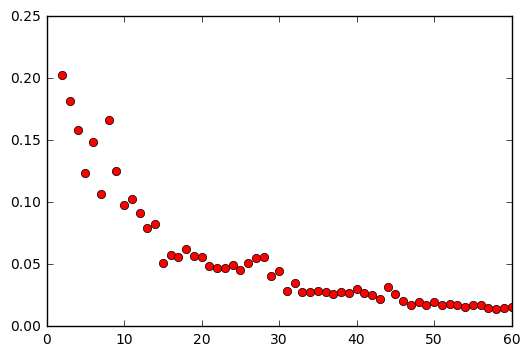

In [61]:
#naive python
#choose K

start = timer()
rmse=[];
for k in range(begin,end):
    P = np.random.rand(countuser,k);
    Q = np.random.rand(countitem,k);
    nP, nQ = changed_matrix_factorization(ratemat, P, Q, k,none_zero, steps, 0.001)
    #nP, nQ = matrix_factorization(ratemat, P, Q, k, steps, 0.001)
    error=rmse_cal(ratemat,nP,nQ,none_zero,num);
    rmse.append(error);
    
dt = timer() - start
print "finished in %f s" % dt

K=range(begin,end);
plt.plot(K, rmse, 'ro');
plt.show();

In [ ]:
#if steps=100, rate=0.01, num=100,  25 is best for k
#if steps=200, rate=0.001, num=500, 30 is best for k
#if steps=200, rate=0.001, num=1000, 30 is best for k

finished in 183.312216 s


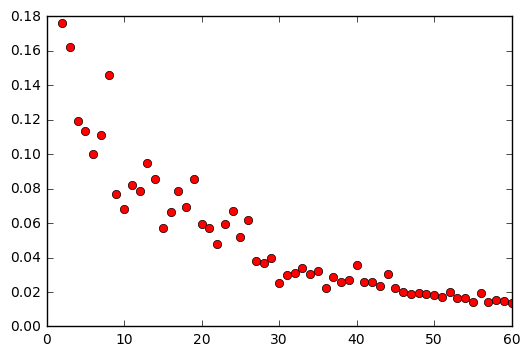

In [62]:
#gpu numbapro
#choose K

start = timer()
rmse=[];
for k in range(begin,end):
    P = np.random.rand(countuser,k);
    Q = np.random.rand(countitem,k);
    nP, nQ = gpu_matrix_factorization(ratemat, P, Q, k,none_zero, steps, 0.001)
    error=gpu_rmse_cal(ratemat,nP,nQ,none_zero,num);
    rmse.append(error);
    
dt = timer() - start
print "finished in %f s" % dt

K=range(begin,end);
plt.plot(K, rmse, 'ro');
plt.show();